# Feature 

In [445]:
import requests as rq
import json
import numpy as np
import pickle
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import snownlp
from tqdm import tqdm
from time import sleep
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from textblob import TextBlob
from snownlp import SnowNLP


<font size=6>Read file</font>

In [446]:
train = pd.read_pickle('C:/Users/88690/Desktop/人工/NYCU-Intro-AI-Project/final-project/nytimes-dataset/train_modified.pkl')
feat_data = 'feat_modified_notready'

train


,web_url,print_section,print_page,news_desk,section_name,type_of_material,word_count,subsection_name,pub_year,pub_month,...,abstract_len,abstract_dup,headline,headline_len,headline_dup,headline_kicker,len_lead,keywords,authors,n_comment
0,https://www.nytimes.com/2020/12/31/opinion/202...,A,18,OpEd,Opinion,Op-Ed,882,NaN,2021,1,...,8,0,Things Will Get Better. Seriously.,5,0,None,54,"[Biden, Joseph R Jr, United States Economy, La...",[Paul Krugman],854
1,https://www.nytimes.com/2021/01/01/sports/ncaa...,B,9,Sports,Sports,News,1316,College Football,2021,1,...,27,0,"In Pasadena, Moving the Rose Bowl Makes For Un...",10,0,None,48,"[Football (College), Rose Bowl (Football Game)...",[Billy Witz],61
2,https://www.nytimes.com/2021/01/01/well/family...,NaN,NaN,Well,Well,News,1044,Family,2021,1,...,33,0,Teaching My Child to Love a Dying World,8,0,Ties,85,"[Trees and Shrubs, Children and Childhood, Par...",[Shoshana Meira Friedman],65
3,https://www.nytimes.com/2021/01/01/upshot/why-...,B,5,Upshot,The Upshot,News,1462,NaN,2021,1,...,23,0,Why Markets Boomed in a Year of Human Misery,9,0,None,30,"[United States Economy, Labor and Jobs, Consum...","[Neil Irwin, Weiyi Cai]",418
4,https://www.nytimes.com/2021/01/01/climate/tru...,A,19,Climate,Climate,News,1582,NaN,2021,1,...,25,0,"How Trump Tried, but Largely Failed, to Derail...",12,0,None,49,"[Global Warming, Environment, Research, United...",[Christopher Flavelle],10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20108,https://www.nytimes.com/2022/12/31/opinion/sou...,NaN,NaN,OpEd,Opinion,Op-Ed,2021,NaN,2022,12,...,11,0,The Shameful Open Secret Behind Southwest’s Fa...,7,0,Zeynep Tufekci,47,"[Southwest Airlines Company, AIRLINES AND AIRP...",[Zeynep Tufekci],550
20109,https://www.nytimes.com/2022/12/31/opinion/202...,SR,2,OpEd,Opinion,Op-Ed,984,NaN,2022,12,...,18,0,Cheer Up! The World Is Better Off Than You Think.,10,0,Nicholas Kristof,16,"[Two Thousand Twenty Two, Coronavirus (2019-nC...",[Nicholas Kristof],311
20110,https://www.nytimes.com/2022/12/31/us/politics...,NaN,NaN,Investigative,U.S.,News,7958,Politics,2022,12,...,22,0,The Invention of Elise Stefanik,5,0,None,5,"[Stefanik, Elise, Trump, Donald J, Republican ...",[Nicholas Confessore],814
20111,https://www.nytimes.com/2022/12/31/world/asia/...,NaN,NaN,Foreign,World,News,3523,Asia Pacific,2022,12,...,33,0,Russia’s War Could Make It India’s World,7,0,None,47,"[vis-photo, International Relations, Politics ...","[Roger Cohen, Mauricio Lima]",325


<font size=6>Set bound of popularity</font>

In [447]:
median = train['n_comment'].median()
print(median)
#train['is_popular'] = train['n_comment'].apply(lambda x : 1 if x > median else 0)
train['is_popular'] = train['n_comment'].apply(lambda x : 1 if x > 135 else 0)
pop_count = 0
for i in train['is_popular']:
    if i:
        pop_count += 1
print('popular:    ' , pop_count / len(train))
print('not popular:' , 1 - pop_count / len(train))
#train = train.drop(columns = ['n_comment'])

59.0
popular:     0.3015462636106001
not popular: 0.6984537363893999


In [448]:
print(train.columns)

Index(['web_url', 'print_section', 'print_page', 'news_desk', 'section_name',
       'type_of_material', 'word_count', 'subsection_name', 'pub_year',
       'pub_month', 'pub_day', 'pub_weekday', 'pub_time', 'abstract',
       'abstract_len', 'abstract_dup', 'headline', 'headline_len',
       'headline_dup', 'headline_kicker', 'len_lead', 'keywords', 'authors',
       'n_comment', 'is_popular'],
      dtype='object')


<font size=6>Hour</font>


pub_time
0     0.559687
1     0.367041
2     0.238663
3     0.200000
4     0.142012
5     0.175258
6     0.068027
7     0.336967
8     0.343419
9     0.337671
10    0.323240
11    0.134269
12    0.229508
13    0.174242
14    0.213078
15    0.275488
16    0.307853
17    0.258824
18    0.249651
19    0.352624
20    0.322470
21    0.292473
22    0.244660
23    0.496084
Name: is_popular, dtype: float64
0.08462384574143528


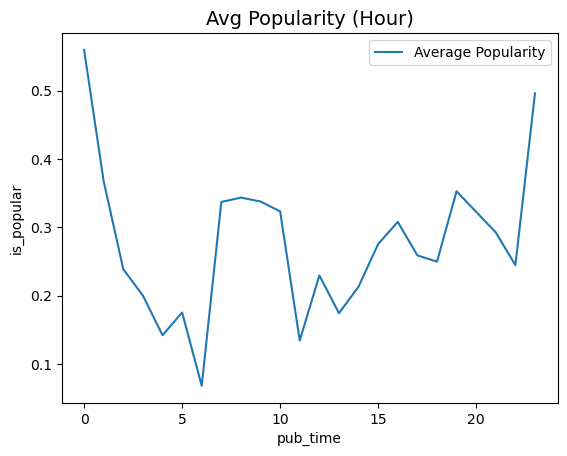

In [449]:
print(train.groupby('pub_time').mean()['is_popular'])
sns.lineplot(data = train.groupby('pub_time').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (Hour)', fontsize=14)
#plt.axvline(x = 3, linestyle= '--')

train['is_noon'] = train['pub_time'].apply(lambda x : 1 if (x <= 3 or x >= 23) else 0)
print(train.corr()['is_popular']['is_noon'])

<font size=6>Weekday</font>

In [450]:
print(train.groupby('pub_weekday').mean()['is_popular'])

pub_weekday
0    0.294782
1    0.297223
2    0.275500
3    0.288331
4    0.290454
5    0.456140
6    0.352159
Name: is_popular, dtype: float64


<font size=6>Day of week</font>

0.08036036772759494


Text(0.5, 1.0, 'Avg Popularity (Day of Week)')

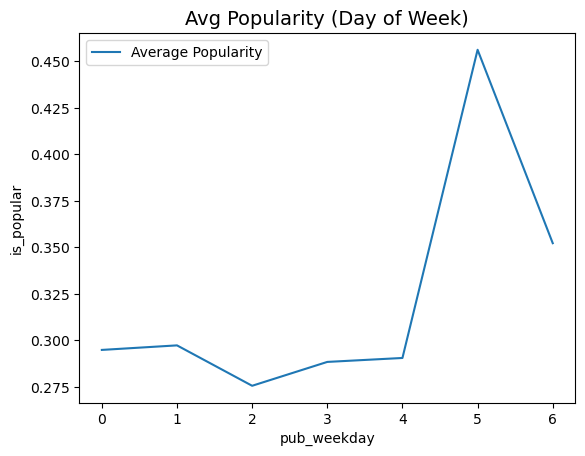

In [451]:
train['is_saturday'] = train['pub_weekday'].apply(lambda x : 1 if (x == 5) else 0)
print(train.corr()['is_popular']['is_saturday'])
sns.lineplot(data = train.groupby('pub_weekday').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (Day of Week)', fontsize=14)


<font size=6>Day of month</font>

pub_day
1     0.326118
2     0.307099
3     0.311844
4     0.294656
5     0.290164
6     0.314729
7     0.274286
8     0.292000
9     0.312409
10    0.297218
11    0.303704
12    0.312012
13    0.300860
14    0.311649
15    0.314815
16    0.302496
17    0.317293
18    0.293930
19    0.295522
20    0.302469
21    0.279370
22    0.302098
23    0.283699
24    0.302251
25    0.297872
26    0.325806
27    0.295385
28    0.302726
29    0.289676
30    0.294821
31    0.295455
Name: is_popular, dtype: float64


Text(0.5, 1.0, 'Avg Popularity (day)')

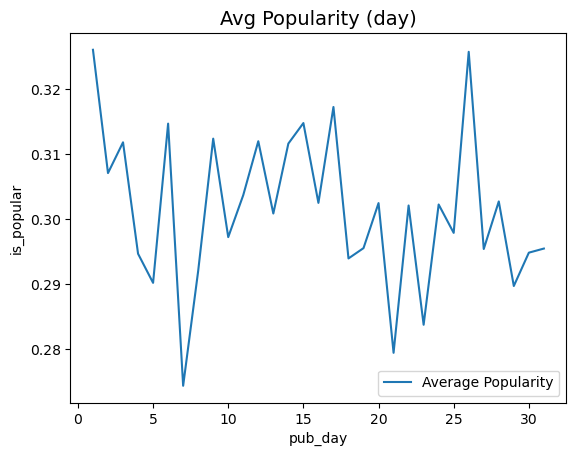

In [452]:
print(train.groupby('pub_day').mean()['is_popular'])
sns.lineplot(data = train.groupby('pub_day').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (day)', fontsize=14)

<font size=6>Month</font>

pub_month
1     0.323386
2     0.303990
3     0.280064
4     0.291831
5     0.253931
6     0.294441
7     0.313016
8     0.326480
9     0.289007
10    0.312032
11    0.321362
12    0.315947
Name: is_popular, dtype: float64
0.08558426276644868


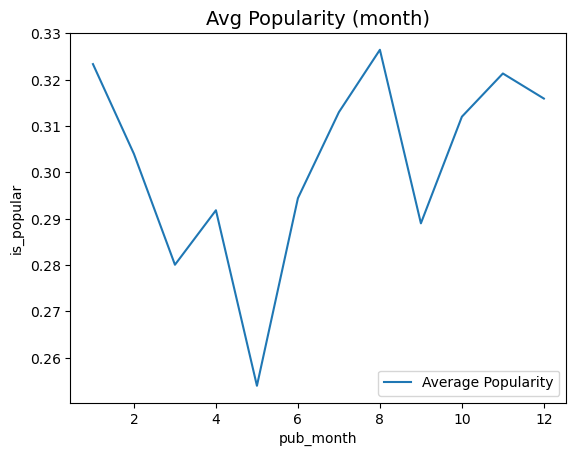

In [453]:
print(train.groupby('pub_month').mean()['is_popular'])
sns.lineplot(data = train.groupby('pub_month').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (month)', fontsize=14)
train['is_lowmonth'] = train['pub_time'].apply(lambda x : 0 if (x >= 3 and x <= 6) else 1)
print(train.corr()['is_popular']['is_lowmonth'])
#print(train.corr()['is_popular']['is_noon'])

<font size=6>News desk</font>

In [454]:
train['group_by_news_desk'] = train['is_popular'].groupby(train['news_desk']).transform('mean')
#train
#train = train.sort_values(['group_by_news_desk'],ascending=False)
print(train.corr()['is_popular']['group_by_news_desk'])
train['feature_news_desk'] = train['group_by_news_desk'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular']['feature_news_desk'])

0.5329630776512312
0.5300662894788436


<font size=6>Section</font>

In [455]:
train['group_by_section_name'] = train['is_popular'].groupby(train['section_name']).transform('mean')
#train = train.sort_values(['group_by_section_name'],ascending=False)
print(train.corr()['is_popular']['group_by_section_name'])
train['feature_section_name'] = train['group_by_news_desk'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular']['feature_section_name'])

0.5248960250019591
0.5300662894788436


<font size=6>Subsection</font>

In [456]:
train['group_by_subsection_name'] = train['is_popular'].groupby(train['subsection_name']).transform('mean')
##train = train.sort_values(['group_by_subsection_name'],ascending=False)
print(train.corr()['is_popular']['group_by_subsection_name'])
train['feature_subsection_name'] = train['group_by_subsection_name'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular']['feature_subsection_name'])

0.4987354157218414
0.49452112163146167


<font size=6>Material</font>

In [457]:
train['group_by_type_of_material'] = train['is_popular'].groupby(train['type_of_material']).transform('mean')
train = train.sort_values(['group_by_type_of_material'],ascending=False)
print(train.corr()['is_popular']['group_by_type_of_material'])
train['feature_type_of_material'] = train['group_by_type_of_material'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular']['feature_type_of_material'])

0.43490883464018
0.43415230637264196


<font size=6>Keyword</font>

<font size=5>Politics<font size=4>( party, congress, president )</font></font>


In [458]:
train['is_party'] = train['keywords'].apply(lambda x: 1 if ('Democratic Party' in x or 'Republican Party' in x ) else 0)
train['is_congress'] = train['keywords'].apply(lambda x: 1 if ('House of Representatives' in x or 'Senate' in x) else 0)
train['is_president'] = train['keywords'].apply(lambda x: 1 if ('Trump, Donald J' in x or 'Biden, Joseph R Jr' in x)else 0)
print(train.corr()['is_popular']['is_party'])
print(train.corr()['is_popular']['is_congress'])
print(train.corr()['is_popular']['is_president'])

0.24669814549721253
0.15277926834794522
0.2689534822804183


<font size=5>Event <font size=4>( Ukrainian_Russian_war, covid, Storming of the US Capitol )</font></font>


In [459]:
train['is_ukrainian_russian_war'] = train['keywords'].apply(lambda x: 1 if ('War and Armed Conflicts' in x or 'Ukraine' in x ) else 0)
train['is_covid'] = train['keywords'].apply(lambda x: 1 if 'Coronavirus (2019-nCoV)' in x else 0)
train['is_storm'] = train['keywords'].apply(lambda x: 1 if 'Storming of the US Capitol (Jan, 2021)' in x else 0)
print('ukrainian_russian_war     ', train.corr()['is_popular']['is_ukrainian_russian_war'])
print('Coronavirus               ', train.corr()['is_popular']['is_covid'])
print('Storming of the US Capitol', train.corr()['is_popular']['is_storm'])

ukrainian_russian_war      0.04450049585106436
Coronavirus                0.020269966821777823
Storming of the US Capitol 0.14569340913641157


<font size=5>News game<font size=4>(spelling bee, crossword puzzle)</font></font>

In [460]:
train['is_spell'] = train['keywords'].apply(lambda x: 1 if 'Spelling Bee (Game)' in x else 0)
train['is_crossword'] = train['keywords'].apply(lambda x: 1 if 'Crossword Puzzles' in x else 0)
train['is_game'] = train['keywords'].apply(lambda x: 1 if 'Spelling Bee (Game)'  in x or 'Crossword Puzzles' in x else 0)
print(train.corr()['is_popular']['is_spell'])
print(train.corr()['is_popular']['is_crossword'])
print(train.corr()['is_popular']['is_game'])

0.14156271477409618
-0.05835095083281426
0.050503439508256046


<font size=6>Headline length</font>

-0.01354521610254337


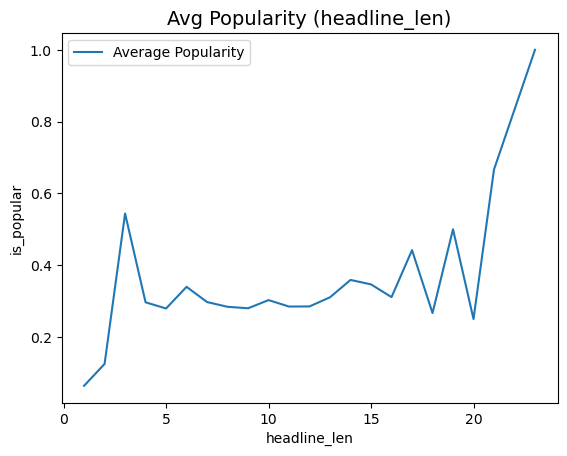

In [461]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.lineplot(data = train.groupby('headline_len').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (headline_len)', fontsize=14)
print(train.corr()['is_popular']['headline_len'])

<font size=6>Abstract length</font>

-0.15508601322988882


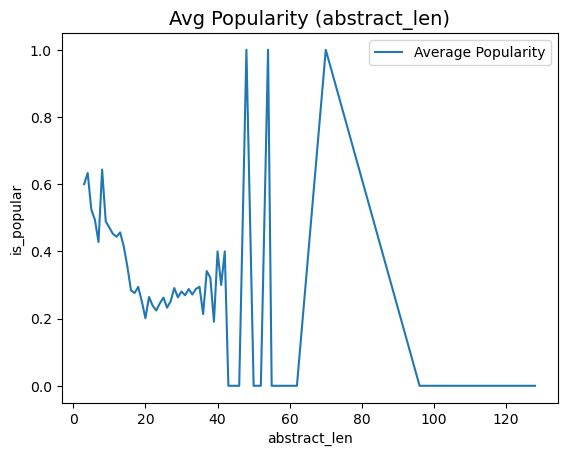

In [462]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.lineplot(data = train.groupby('abstract_len').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (abstract_len)', fontsize=14)
print(train.corr()['is_popular']['abstract_len'])

<font size=6>Word count</font>

0.13498290556701387


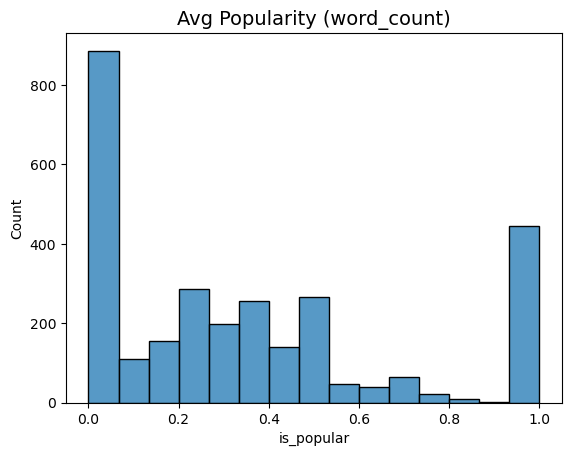

In [463]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.histplot(data = train.groupby('word_count').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (word_count)', fontsize=14)
print(train.corr()['is_popular']['word_count'])

0.15259526468023563


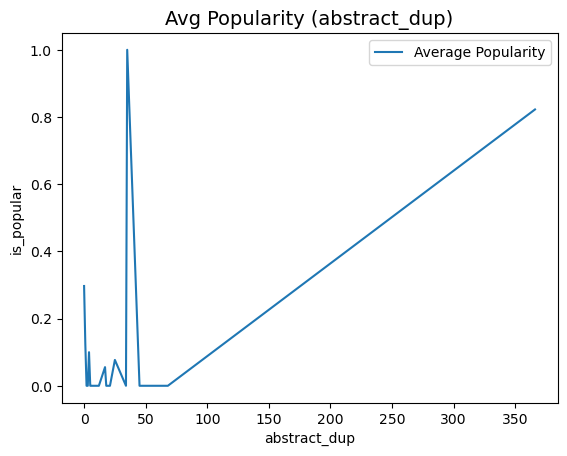

In [464]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.lineplot(data = train.groupby('abstract_dup').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (abstract_dup)', fontsize=14)
print(train.corr()['is_popular']['abstract_dup'])

<font size=6>Lead paragraph length</font>

0.05845063984259898


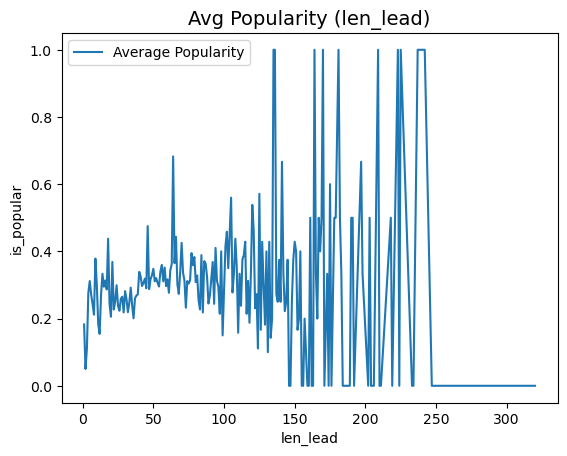

In [465]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.lineplot(data = train.groupby('len_lead').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (len_lead)', fontsize=14)
print(train.corr()['is_popular']['len_lead'])

<font size = 6>Sentiment analyze</font>

<font size = 5>punctuation removal</font>

In [466]:
punct_list = list('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
def remove_punctuation(headline):
    for punc in punct_list:
        if punc in headline:
            headline = headline.replace(punc, ' ')
    return headline
train['clean_headline'] = train['headline'].apply(lambda x: remove_punctuation(x))

<font size = 5>textblob</font>

In [467]:

text = "i am happy today."
blob = TextBlob(text)
# get the sentiment of the text
sentiment = blob.sentiment
print(sentiment)

Sentiment(polarity=0.8, subjectivity=1.0)


In [468]:
def tb_score_polar(headline):
    score = TextBlob(headline).sentiment[0]
    return score
def tb_score_subj(headline):
    score = TextBlob(headline).sentiment[1]
    return score
train['sentiment_tb_polar'] = train['clean_headline'].apply(lambda x : tb_score_polar(x))#-1 ~ 1
train['sentiment_tb_polar_abs'] = train['sentiment_tb_polar'].apply(lambda x :abs(x))#0 ~ 1
train['sentiment_tb_subj'] = train['clean_headline'].apply(lambda x : tb_score_subj(x))#0 ~ 1
train['sentiment_tb_pos'] = train['sentiment_tb_polar'].apply(lambda x : 1 if x > 0 else 0)#bool
print(train.corr()['is_popular']['sentiment_tb_polar'])
print(train.corr()['is_popular']['sentiment_tb_polar_abs'])
print(train.corr()['is_popular']['sentiment_tb_subj'])
print(train.corr()['is_popular']['sentiment_tb_pos'])

-0.030641258503349818
0.0027387269571002544
-0.006149174626970869
-0.024805635316837774


<font size = 5>vader</font>

In [469]:
headline = 'today is a sunny day!'
analyzer = SentimentIntensityAnalyzer ()
sentiment_dict = analyzer.polarity_scores(headline)
print(sentiment_dict)

{'neg': 0.0, 'neu': 0.492, 'pos': 0.508, 'compound': 0.4753}


In [470]:
train['sentiment_vader_neg'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['neg'])#0 ~ 1
train['sentiment_vader_neu'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['neu'])#0 ~ 1
train['sentiment_vader_pos'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['pos'])#0 ~ 1
train['sentiment_vader_compound'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['compound'])#-1 ~ 1
train['sentiment_vader_compound_abs'] = train['sentiment_vader_compound'].apply(lambda x : abs(x))#0 ~ 1
print(train.corr()['is_popular']['sentiment_vader_neg'])
print(train.corr()['is_popular']['sentiment_vader_neu'])
print(train.corr()['is_popular']['sentiment_vader_pos'])
print(train.corr()['is_popular']['sentiment_vader_compound'])
print(train.corr()['is_popular']['sentiment_vader_compound_abs'])

0.10098689046042336
-0.07925170048544851
0.0011037398010215682
-0.06687012808076118
0.06720339999024857


<font size = 5>snownlp</font>

In [471]:
headline = 'i am happy'
sentence = 'hello","why is it not working?!'
s = SnowNLP(headline)
print(s.sentiments)

0.1837233963534416


In [472]:
train['sentiment_snow'] = train['clean_headline'].apply(lambda x : SnowNLP(x).sentiments)#0 ~ 1
train['sentiment_snow_abs'] = train['sentiment_snow'].apply(lambda x : 2 * abs(x - 0.5))#-1 ~ 1
train['sentiment_snow_pos'] = train['sentiment_snow'].apply(lambda x : 1 if x > 0.5 else 0)#bool
print(train.corr()['is_popular']['sentiment_snow'])
print(train.corr()['is_popular']['sentiment_snow_abs'])
print(train.corr()['is_popular']['sentiment_snow_pos'])

-0.012107743585836352
0.039270848211335196
0.0024232445902113015


<font size = 6>abstract</font>

In [473]:
train = train.drop(13348)
train['clean_abstract'] = train['abstract'].apply(lambda x: remove_punctuation(x))

<font size = 5>textblob</font>

In [474]:
def tb_score_polar(headline):
    score = TextBlob(headline).sentiment[0]
    return score
def tb_score_subj(headline):
    score = TextBlob(headline).sentiment[1]
    return score
train['sentiment_abstract_tb_polar'] = train['clean_abstract'].apply(lambda x : tb_score_polar(x))#-1 ~ 1
train['sentiment_abstract_tb_polar_abs'] = train['sentiment_abstract_tb_polar'].apply(lambda x :abs(x))#0 ~ 1
train['sentiment_abstract_tb_subj'] = train['clean_abstract'].apply(lambda x : tb_score_subj(x))#0 ~ 1
train['sentiment_abstract_tb_pos'] = train['sentiment_abstract_tb_polar'].apply(lambda x : 1 if x > 0 else 0)#bool
print(train.corr()['is_popular']['sentiment_abstract_tb_polar'])
print(train.corr()['is_popular']['sentiment_abstract_tb_polar_abs'])
print(train.corr()['is_popular']['sentiment_abstract_tb_subj'])
print(train.corr()['is_popular']['sentiment_abstract_tb_pos'])

-0.05519939088640827
-0.043323666965765256
-0.05410323137112291
-0.08632862083604688


<font size = 5>vader</font>

In [475]:
train['sentiment_abstract_vader_neg'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['neg'])#0 ~ 1
train['sentiment_abstract_vader_neu'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['neu'])#0 ~ 1
train['sentiment_abstract_vader_pos'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['pos'])#0 ~ 1
train['sentiment_abstract_vader_compound'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['compound'])#-1 ~ 1
train['sentiment_abstract_vader_compound_abs'] = train['sentiment_vader_compound'].apply(lambda x : abs(x))#0 ~ 1
print(train.corr()['is_popular']['sentiment_abstract_vader_neg'])
print(train.corr()['is_popular']['sentiment_abstract_vader_neu'])
print(train.corr()['is_popular']['sentiment_abstract_vader_pos'])
print(train.corr()['is_popular']['sentiment_abstract_vader_compound'])
print(train.corr()['is_popular']['sentiment_abstract_vader_compound_abs'])

0.14555732070388766
-0.1432129772181723
0.047955581438164266
-0.07214721966833976
0.06717685662888834


<font size = 5>snownlp</font>

In [476]:
train['sentiment_abstract_snow'] = train['clean_abstract'].apply(lambda x : SnowNLP(x).sentiments)#0 ~ 1
train['sentiment_abstract_snow_abs'] = train['sentiment_abstract_snow'].apply(lambda x : 2 * abs(x - 0.5))#-1 ~ 1
train['sentiment_abstract_snow_pos'] = train['sentiment_abstract_snow'].apply(lambda x : 1 if x > 0.5 else 0)#bool
print(train.corr()['is_popular']['sentiment_abstract_snow'])
print(train.corr()['is_popular']['sentiment_abstract_snow_abs'])
print(train.corr()['is_popular']['sentiment_abstract_snow_pos'])

0.09359271190877337
-0.12014436772003656
0.009980854982231693


In [477]:
train = train.drop(columns=['web_url', 'print_section', 'print_page', 'pub_year',
       'abstract','abstract_dup', 'headline', 
       'headline_dup', 'headline_kicker', 'pub_weekday'])

In [478]:
fea_list = train.corr()['is_popular']
fea_list = fea_list.sort_values(key = lambda x : abs(x), ascending=False)
print(fea_list)

is_popular                               1.000000
n_comment                                0.678471
group_by_news_desk                       0.532955
feature_news_desk                        0.530060
feature_section_name                     0.530060
group_by_section_name                    0.524888
group_by_subsection_name                 0.498735
feature_subsection_name                  0.494521
group_by_type_of_material                0.434905
feature_type_of_material                 0.434148
is_president                             0.268946
is_party                                 0.246692
abstract_len                            -0.155142
is_congress                              0.152775
is_storm                                 0.145690
sentiment_abstract_vader_neg             0.145557
sentiment_abstract_vader_neu            -0.143213
is_spell                                 0.141560
word_count                               0.134963
sentiment_abstract_snow_abs             -0.120144


In [479]:
suit_attribute = []
for i in range(40):
    suit_attribute.append(fea_list.index[i])
for col in train.columns:
    if col not in suit_attribute:
        train = train.drop(columns = col)
        print(col)
        
#print(list.columns)
#list.sort_values(list, key = lambda x: x[1])
#print(list)

news_desk
section_name
type_of_material
subsection_name
pub_month
pub_day
pub_time
headline_len
keywords
authors
is_covid
clean_headline
sentiment_tb_polar
sentiment_tb_polar_abs
sentiment_tb_subj
sentiment_tb_pos
sentiment_vader_pos
sentiment_snow
sentiment_snow_pos
clean_abstract
sentiment_abstract_snow_pos


In [480]:
print(train.corr()['is_popular'])

word_count                               0.134963
abstract_len                            -0.155142
len_lead                                 0.058429
n_comment                                0.678471
is_popular                               1.000000
is_noon                                  0.084613
is_saturday                              0.080354
is_lowmonth                              0.085594
group_by_news_desk                       0.532955
feature_news_desk                        0.530060
group_by_section_name                    0.524888
feature_section_name                     0.530060
group_by_subsection_name                 0.498735
feature_subsection_name                  0.494521
group_by_type_of_material                0.434905
feature_type_of_material                 0.434148
is_party                                 0.246692
is_congress                              0.152775
is_president                             0.268946
is_ukrainian_russian_war                 0.044495


In [481]:
'''
train = train.drop(columns=['n_comment', 'group_by_news_desk', 'group_by_section_name', 'group_by_subsection_name',
                            'group_by_type_of_material', 'feature_news_desk', 'feature_subsection_name',
                            'sentiment_vader_neu', 'sentiment_vader_compound_abs', 'sentiment_abstract_snow',
                            'sentiment_abstract_vader_compound', 'sentiment_vader_compound', 'sentiment_abstract_vader_neu',
                            'is_game', 'sentiment_tb_pos', 'sentiment_abstract_tb_pos'])
train.columns
'''
                            

"\ntrain = train.drop(columns=['n_comment', 'group_by_news_desk', 'group_by_section_name', 'group_by_subsection_name',\n                            'group_by_type_of_material', 'feature_news_desk', 'feature_subsection_name',\n                            'sentiment_vader_neu', 'sentiment_vader_compound_abs', 'sentiment_abstract_snow',\n                            'sentiment_abstract_vader_compound', 'sentiment_vader_compound', 'sentiment_abstract_vader_neu',\n                            'is_game', 'sentiment_tb_pos', 'sentiment_abstract_tb_pos'])\ntrain.columns\n"

<AxesSubplot:>

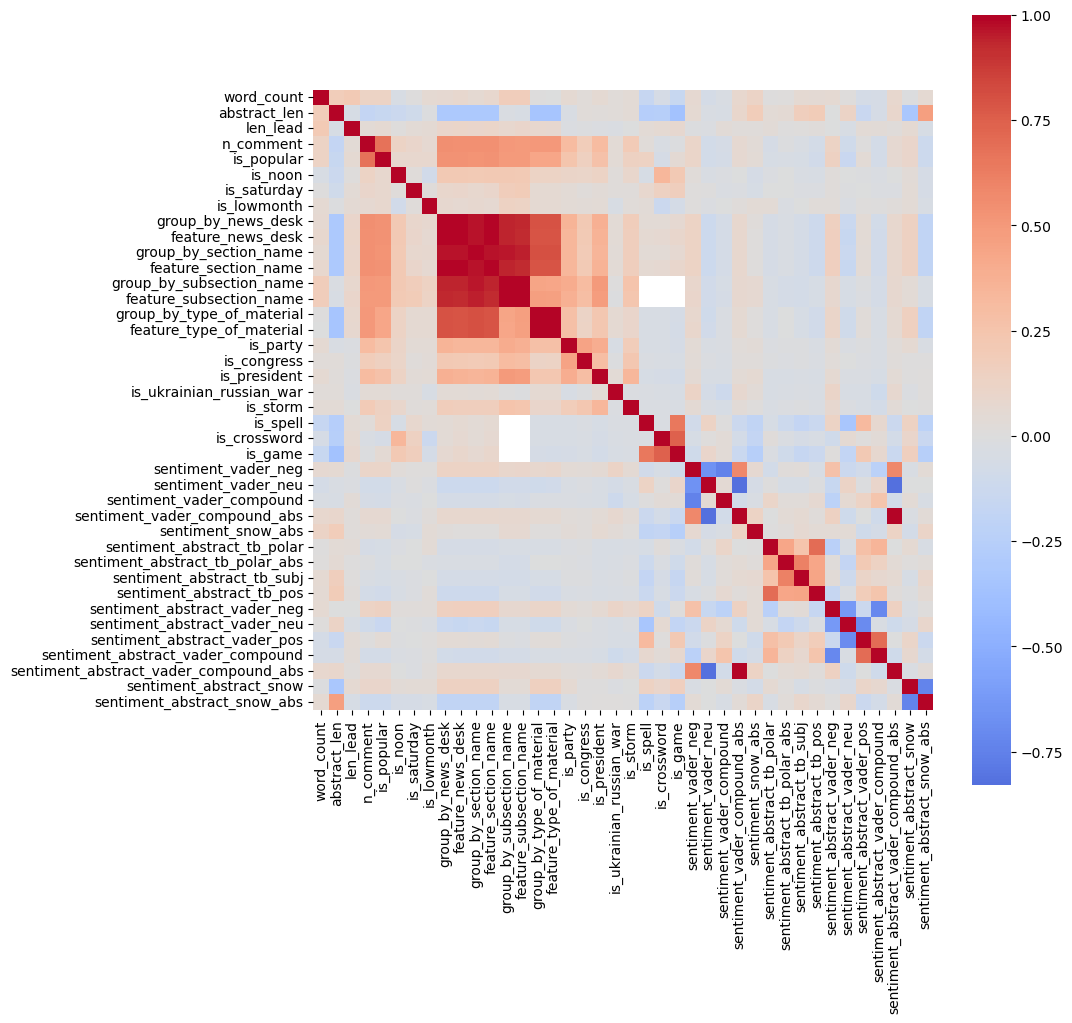

In [485]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), cmap='coolwarm', annot=False, square=True, fmt='.2f', cbar=True, center = 0)

<AxesSubplot:>

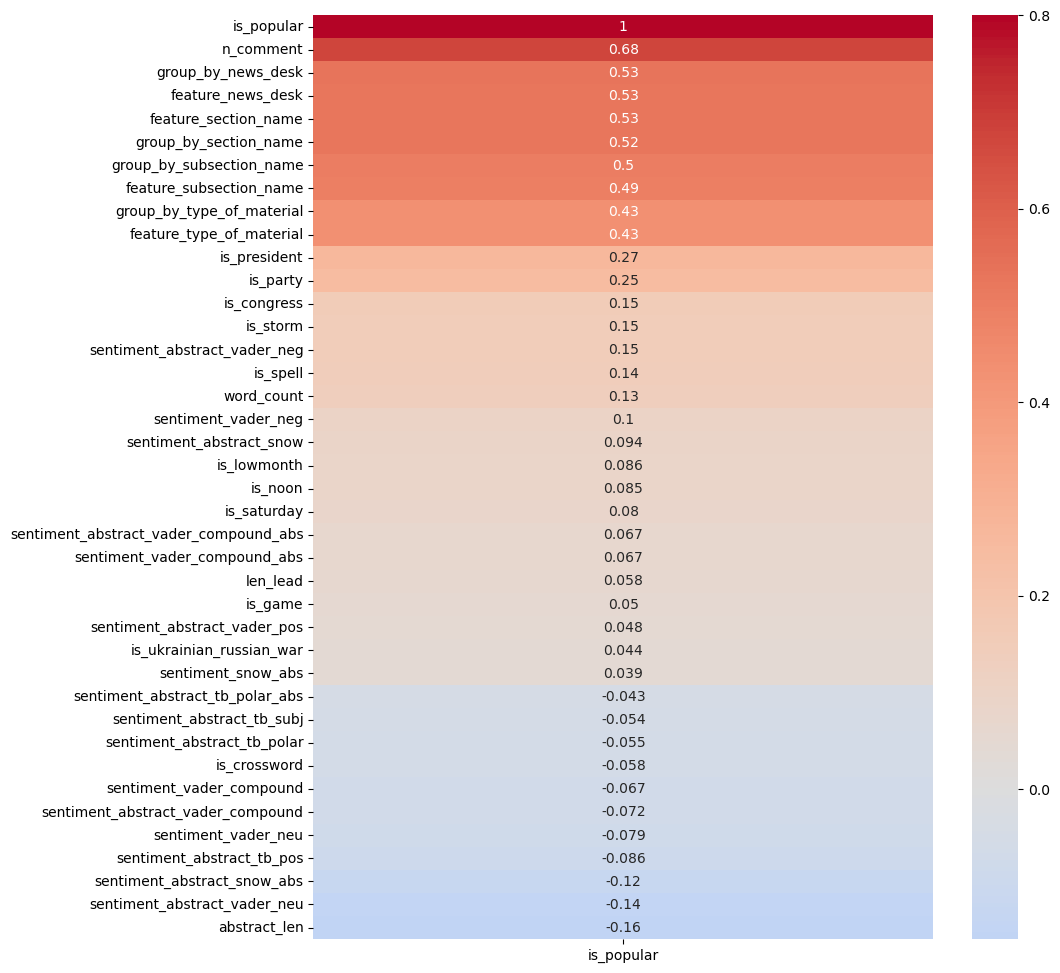

In [483]:
plt.figure(figsize=(10,12))
sns.heatmap(train.corr()[['is_popular']].sort_values(ascending=False, by='is_popular'), 
            cmap='coolwarm', annot=True, vmax=0.8, center=0)

# Check the features

In [484]:
train.to_pickle(f'./feature/{feat_data}.pkl')
feat = pd.read_pickle(f'./feature/{feat_data}.pkl')
feat

,word_count,abstract_len,len_lead,n_comment,is_popular,is_noon,is_saturday,is_lowmonth,group_by_news_desk,feature_news_desk,...,sentiment_abstract_tb_polar_abs,sentiment_abstract_tb_subj,sentiment_abstract_tb_pos,sentiment_abstract_vader_neg,sentiment_abstract_vader_neu,sentiment_abstract_vader_pos,sentiment_abstract_vader_compound,sentiment_abstract_vader_compound_abs,sentiment_abstract_snow,sentiment_abstract_snow_abs
0,882,8,54,854,1,1,0,1,0.843619,0.8,...,0.000000,0.000000,0,0.000,0.680,0.320,0.5106,0.2960,0.421875,0.156251
7674,1159,16,42,409,1,0,0,1,0.843619,0.8,...,0.400000,0.700000,1,0.133,0.867,0.000,-0.2500,0.4404,0.111855,0.776289
7680,874,8,18,619,1,1,0,1,0.843619,0.8,...,0.472222,0.438889,0,0.229,0.508,0.263,0.1010,0.0000,0.267326,0.465347
7688,1021,7,59,280,1,0,0,1,0.843619,0.8,...,0.100000,0.000000,1,0.000,1.000,0.000,0.0000,0.7096,0.164643,0.670715
7710,1942,8,40,410,1,0,0,1,0.843619,0.8,...,0.500000,0.687500,1,0.000,0.541,0.459,0.6249,0.0000,0.396490,0.207019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18044,1537,24,41,8,0,0,0,1,0.191358,0.2,...,0.068182,0.477273,1,0.000,1.000,0.000,0.0000,0.3400,0.220917,0.558166
16621,1312,26,44,30,0,0,0,1,0.191358,0.2,...,0.000000,0.000000,0,0.000,1.000,0.000,0.0000,0.5994,0.113196,0.773608
9178,1502,11,37,10,0,0,0,1,0.191358,0.2,...,0.000000,0.000000,0,0.237,0.763,0.000,-0.4767,0.4404,0.371652,0.256697
18081,1525,28,35,6,0,0,0,0,0.191358,0.2,...,0.000000,1.000000,0,0.153,0.801,0.045,-0.4767,0.0000,0.039727,0.920546


Index([ 'print_section', 'print_page', 'pub_year',
       'abstract','abstract_dup', 'headline', 
       'headline_dup', 'headline_kicker', 'len_lead', 
       'is_popular'],
      dtype='object')